In [1]:
import anndata as ad
import pandas as pd
import shapely
import shapely.plotting as splot
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

import ccf_plots as cplots
import abc_load as abc
get_ipython().run_line_magic('matplotlib', 'inline') 

# Load brain3 data

### alternate versions

In [2]:
rename = {
    'x_section':'cirro_x',
    'y_section':'cirro_y',
}
ccf_label = 'parcellation_substructure_realigned'

obs = pd.read_parquet("/data/realigned/abc_realigned_metadata_thalamus-boundingbox.parquet")
# obs = pd.read_parquet("/data/realigned-metadata/abc_realigned_metadata_thalamus-boundingbox.parquet")
obs = obs.rename(columns=rename)
# hack to use old taxonomy labels
obs_old = abc.get_combined_metadata(version="20230630")
obs.update(obs_old)
nn_classes = [
    "28 Astro-Epen",
    "29 Oligo",
    "31 Vascular",
    "32 Immune",
]
# new taxonomy
# nn_classes = [
#     "31 OPC-Oligo",
#     "30 Astro-Epen",
#     "33 Vascular",
#     "34 Immune",
# ]


In [5]:

import nibabel
img = nibabel.load("/data/realigned/abc_realigned_ccf_labels.nii.gz")
# could maybe keep the lazy dataobj and not convert to numpy?
ccf_polygons = np.array(img.dataobj)

In [6]:
# rename = {
#     'x_realigned':'cirro_x',
#     'y_realigned':'cirro_y',
# }
# ccf_label = 'parcellation_substructure'

# obs = abc.get_combined_metadata(version="20230630")
# obs = obs.rename(columns=rename)
# nn_classes = [
#     "28 Astro-Epen",
#     "29 Oligo",
#     "31 Vascular",
#     "32 Immune",
# ]

# ccf_polygons = abc.get_ccf_labels_image(resampled=True).astype(int)

### preprocessing

In [7]:
section_col = 'z_section'
obs[section_col] = obs[section_col].round(1)

In [8]:
th_names = abc.get_thalamus_substructure_names()
th_subregion_names = list(set(th_names).difference(['TH-unassigned']))

In [9]:
# subset just the neurons
obs_neurons = obs[~obs['class'].isin(nn_classes)]
obs_th = obs[obs[ccf_label].isin(th_names)]


In [10]:
obs_th_neurons = obs[obs[ccf_label].isin(th_names) & ~obs['class'].isin(nn_classes)]
# helps plotting etc by trimming categories
obs_th_neurons = obs_th_neurons.assign(
    **obs_th_neurons.select_dtypes(include=["category"]).apply(lambda x: x.cat.remove_unused_categories()).to_dict(orient='series'))

In [11]:

sections_all = sorted(obs_th_neurons[section_col].unique())
sections_3 = [5.6, 6.4, 7.2]

## view thalamus subset with subclass labels

In [12]:
from importlib import reload
reload(abc)
reload(cplots)

<module 'ccf_plots' from '/root/capsule/code/ccf_plots.py'>

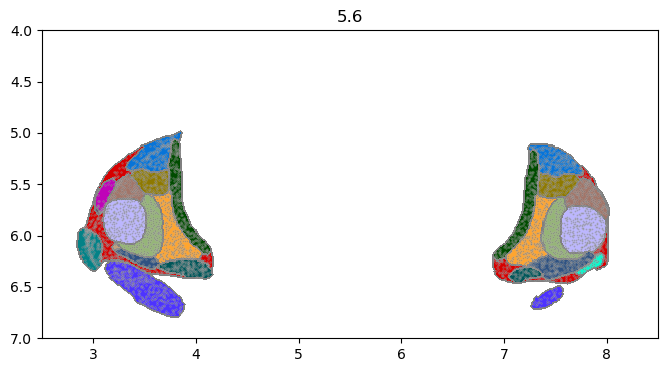

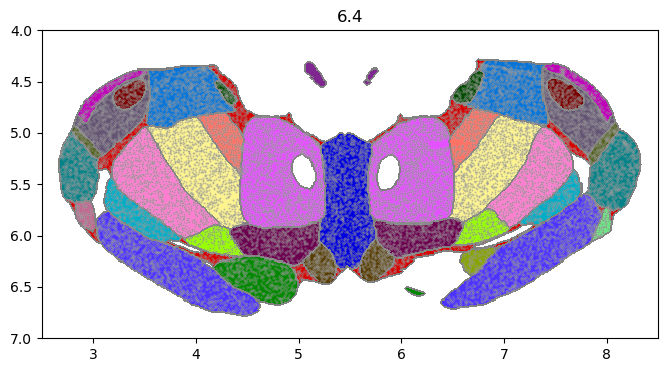

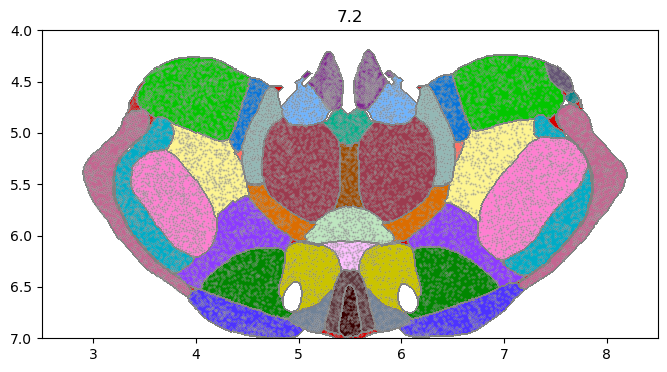

In [13]:
# may need to tweak clustering params on fine 
cplots.plot_ccf_overlay(obs_th.iloc[[],:],#no foreground cells
                        ccf_polygons, point_hue=ccf_label, sections=sections_3, highlight='all', section_col=section_col,
                           # x_field='x_section', y_field='y_section',
                 bg_cells=obs_th, bg_shapes=False, min_group_count=0, legend=False, axes=True)

In [14]:
th_subclasses = obs_th_neurons['subclass'].value_counts().loc[lambda x: x>400]
th_subclasses

subclass
069 TH Prkcd Grin2c Glut              38384
081 RT ZI Gnb3 Gaba                    6378
063 MH Tac2 Glut                       4154
072 PF Fzd5 Glut                       3887
067 PVT-PT Ntrk1 Glut                  3751
070 RE-Xi Nox4 Glut                    3565
111 ZI Pax6 Gaba                       3381
068 CM-IAD-CL-PCN Glut                 3222
159 SPA-SPFm-SPFp-POL-PIL-PoT Glut     3220
066 AV Col27a1 Glut                    1642
214 LGv-SPFp-SPFm Gata3 Gaba           1393
126 LGv Otx2 Gaba                      1055
065 AD Serpinb7 Glut                   1055
064 LH Pou4f1 Sox1 Glut                 890
071 MG-POL-SGN Glut                     630
327 Oligo NN                            516
156 APN C1ql4 Glut                      417
Name: count, dtype: int64

In [15]:
len(th_subclasses)

17

In [16]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'class'].value_counts().loc[lambda x: x>0]

class
09 TH Glut       56136
11 HY GABA       10814
08 MH-LH Glut     5044
16 MB Glut        3637
20 MB GABA        1393
31 OPC-Oligo       516
Name: count, dtype: int64

In [17]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'supertype'].unique().shape[0]

89

In [18]:
obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index), 'cluster'].unique().shape[0]

396

In [19]:
from colorcet import glasbey
point_palette = dict(zip(th_subclasses.index, sns.color_palette(glasbey, n_colors=len(th_subclasses.index))))


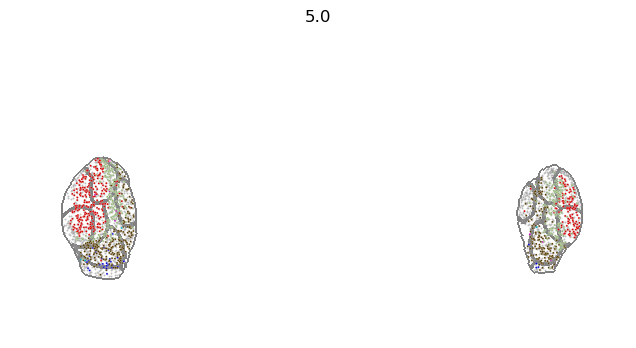

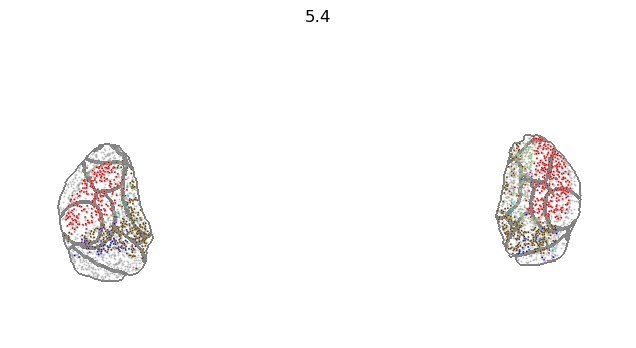

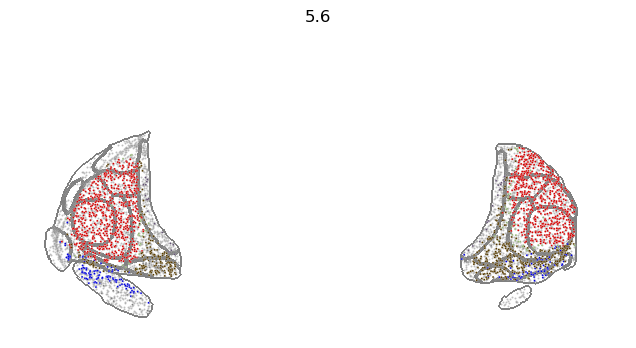

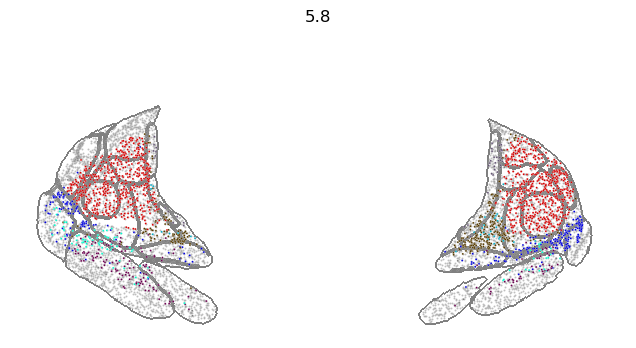

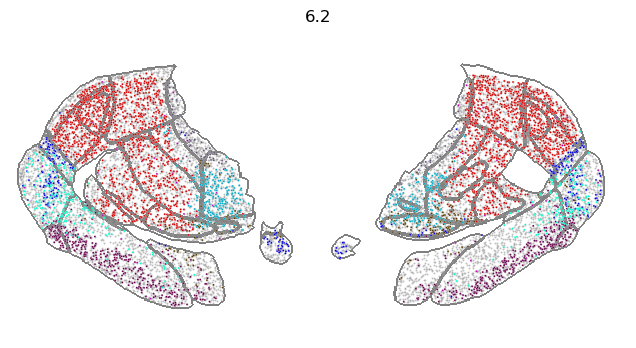

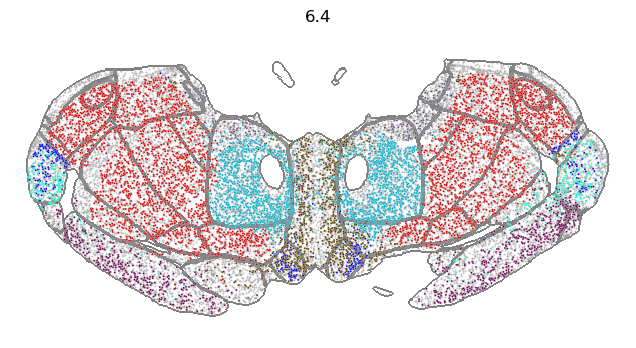

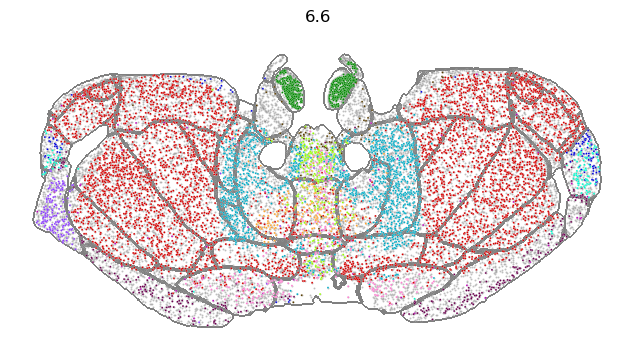

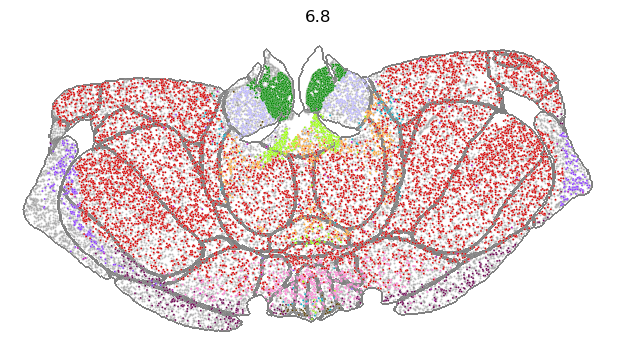

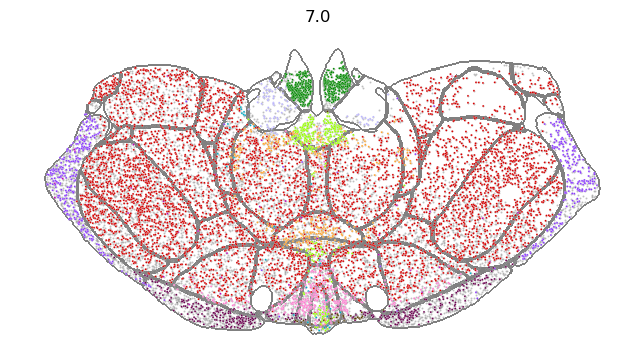

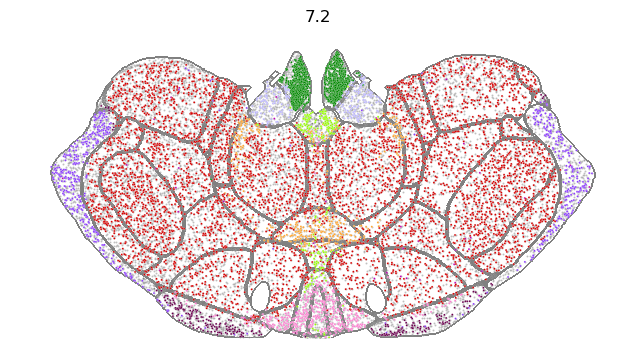

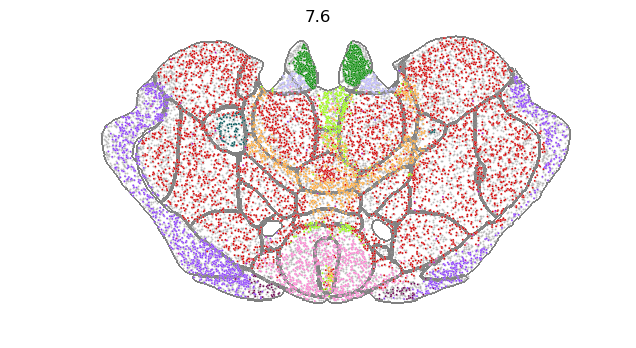

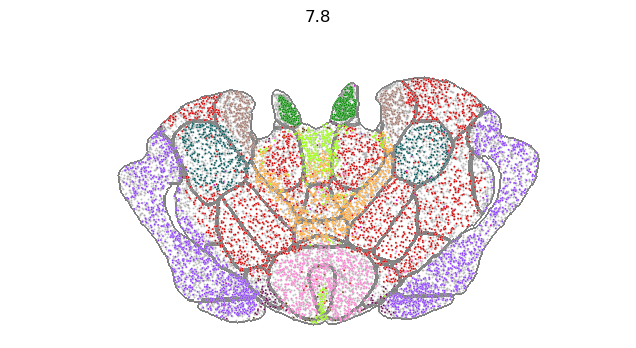

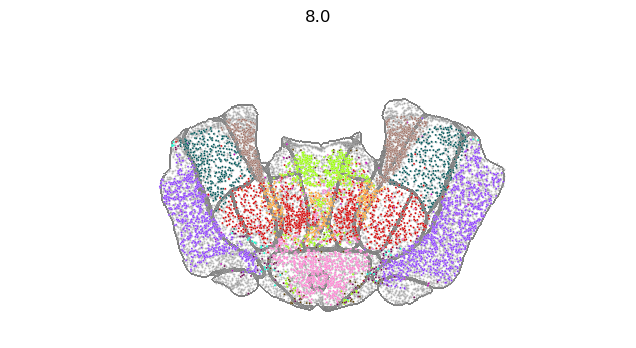

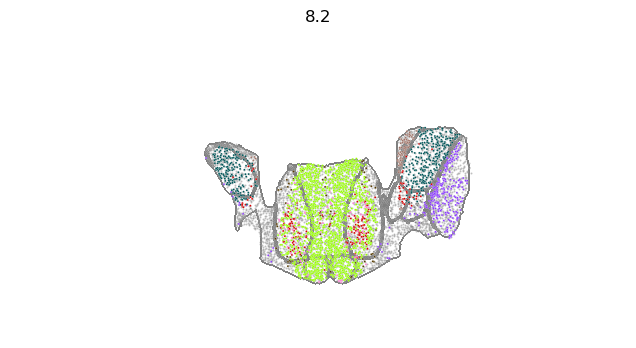

In [20]:
obs = obs_th_neurons.loc[lambda df: df['subclass'].isin(th_subclasses.index)]
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='subclass', sections=sections_all,
                 shape_palette='dark_outline', point_palette=point_palette, legend=False, highlight='all',
                 section_col=section_col,
                           # x_field='x_section', y_field='y_section',
                 min_group_count=30)

## examples

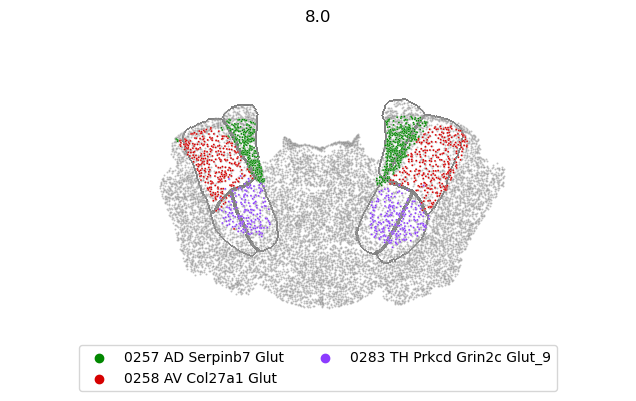

In [21]:
anterior_sec = 8.0
clusters = [str(x) for x in list(range(1169, 1171+1)) + list(range(1095, 1098+1))]
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['AD', 'AV', 'AMd', 'AMv']
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=[anterior_sec],
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

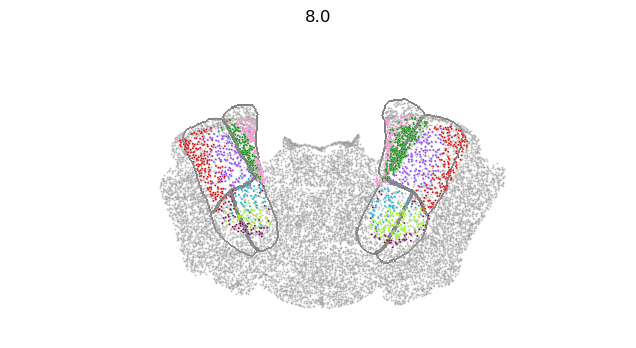

In [22]:

cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='cluster', sections=[anterior_sec],
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend=False, bg_shapes=False, 
                 section_col=section_col)

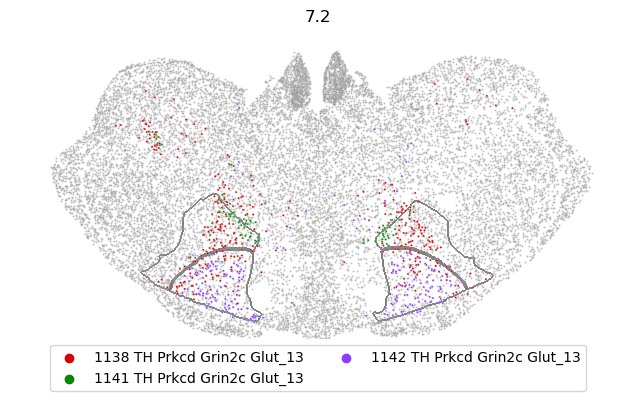

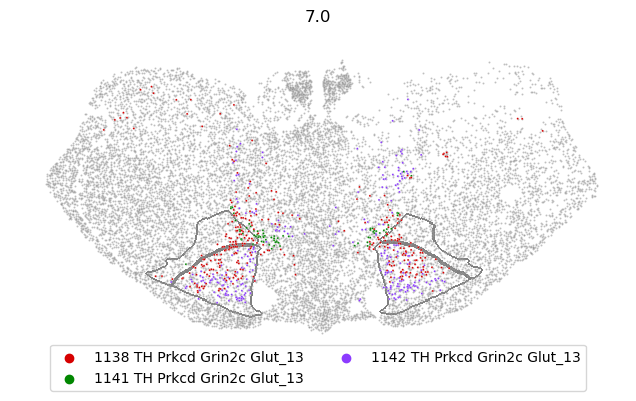

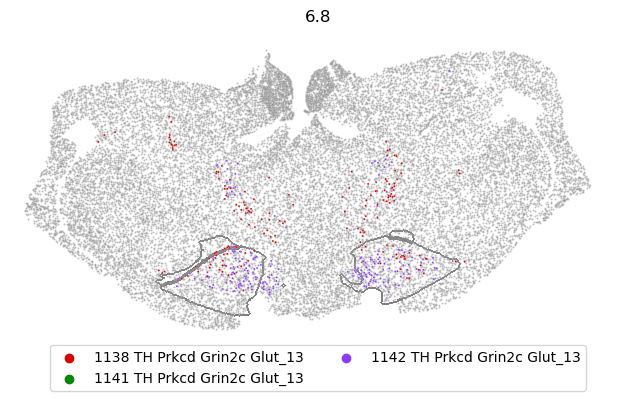

In [23]:
sections = [7.2, 7.0, 6.8]
clusters = ['1138','1141','1142']
obs = obs_th_neurons.loc[lambda df: df['cluster'].str[:4].isin(clusters)]
nuclei = ['VM','VAL']
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='cluster', sections=sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

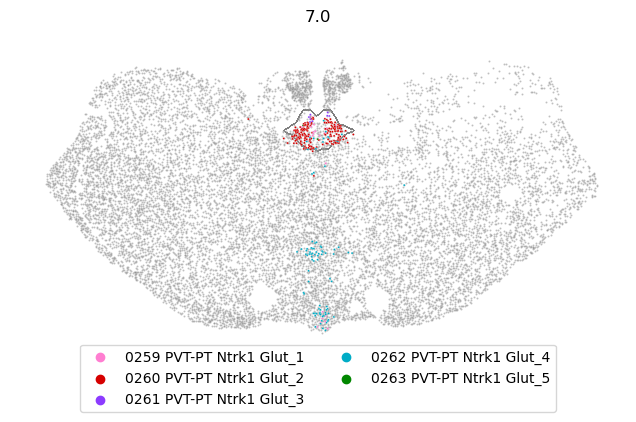

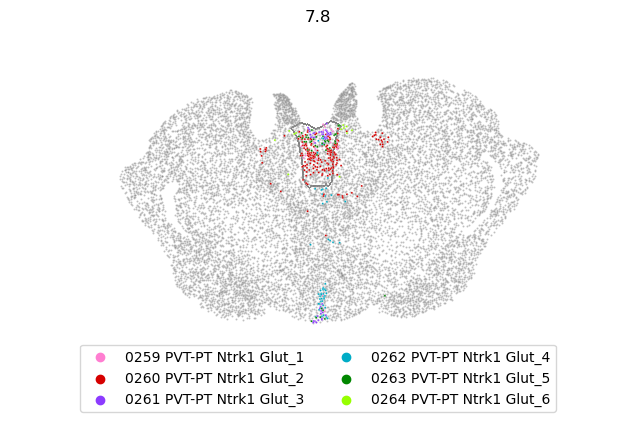

In [24]:
pvt_sections = [7.0, 7.8]
nuclei = ['PVT']
subclasses = nuclei
obs = obs_th_neurons.loc[np.any([obs_th_neurons['subclass'].str.contains(x).values for x in subclasses], axis=0), :]
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=pvt_sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)

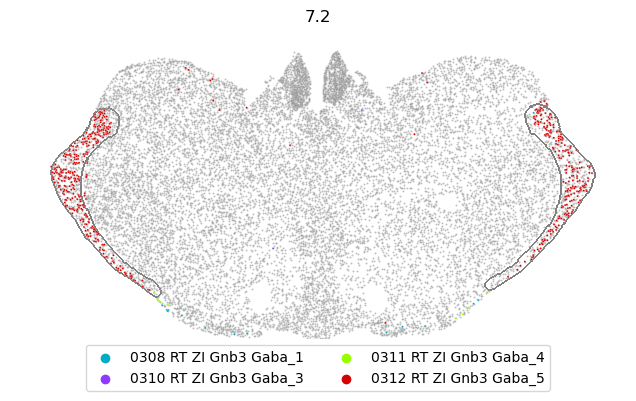

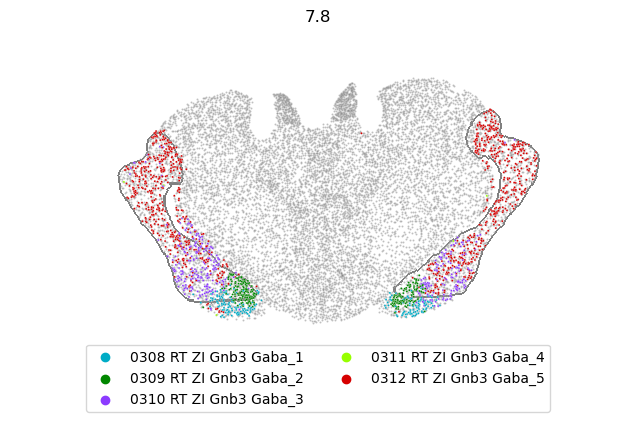

In [25]:
rt_sections = [7.2, 7.8]
nuclei = ['RT']
subclasses = ['RT ZI']
obs = obs_th_neurons.loc[np.any([obs_th_neurons['subclass'].str.contains(x).values for x in subclasses], axis=0), :]
cplots.plot_ccf_overlay(obs, ccf_polygons, bg_cells=obs_th, point_hue='supertype', sections=rt_sections,
                 shape_palette='dark_outline',
                 ccf_names=nuclei, legend='cells', bg_shapes=False, 
                 section_col=section_col)